# Power Plant  Regression with ANN

The purpose of this notebook is to be able to modelise power plant energy system.
Indeed, it is good to know that with few variables it is possible to have a good prediction of the energy created.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('Folds5x2_pp.csv')
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


We cansee that the dataset is composed of around 10 000 values which is a good thing to have relevant predictions.

In [3]:
from sklearn.utils import shuffle

df =  shuffle(df)

### Process of the data

We extract only the numerical data
Afterward we split in a trainning set to train the ANN and in a test set to evaluate the performance of the ANN of real data.

In [4]:
X =  df.drop('PE',axis=1).values
y =  df['PE'].values

print(X)
print(y)

[[  12.28   40.92 1023.23   89.14]
 [  14.93   43.02 1012.11   45.56]
 [  27.98   67.9  1006.3    73.53]
 ...
 [  26.1    44.57 1007.47   55.15]
 [  14.99   41.35 1004.56   98.9 ]
 [  11.48   41.2  1012.88   90.04]]
[460.33 468.19 436.08 ... 446.49 466.85 478.34]


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7654, 4)
(1914, 4)
(7654,)
(1914,)


The use of robust sacler achieve two importants objectives, removing  outliers or at least reducing  their importance and normalise the data for feeding the ANN.

In [6]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=(25.0, 75.0))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

### Creation of the ANN
This ANN has two hidden layers. It's an advanced regressor.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

ann = Sequential([
    Dense(units=6, activation='relu'),
    Dense(units=6, activation='relu'),
    Dense(units=1)
])

2022-06-07 08:38:07.678224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
ann.compile(
    loss='mse',
    optimizer='adam'
)

In [9]:
ann.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test,y_test),
    callbacks=EarlyStopping(monitor='val_loss', patience=4)
)

Epoch 1/100
240/240 [==============================] - 1s 2ms/step - loss: 206378.0938 - val_loss: 205695.3750
Epoch 2/100
240/240 [==============================] - 0s 1ms/step - loss: 202806.9375 - val_loss: 198111.3750
Epoch 3/100
240/240 [==============================] - 0s 1ms/step - loss: 189011.4219 - val_loss: 177257.2031
Epoch 4/100
240/240 [==============================] - 0s 1ms/step - loss: 161318.3906 - val_loss: 142798.7656
Epoch 5/100
240/240 [==============================] - 0s 1ms/step - loss: 122647.4453 - val_loss: 100830.5391
Epoch 6/100
240/240 [==============================] - 0s 1ms/step - loss: 81145.7734 - val_loss: 61078.6797
Epoch 7/100
240/240 [==============================] - 0s 1ms/step - loss: 46201.0820 - val_loss: 31796.6797
Epoch 8/100
240/240 [==============================] - 0s 1ms/step - loss: 23241.9238 - val_loss: 15130.5195
Epoch 9/100
240/240 [==============================] - 0s 1ms/step - loss: 11271.8857 - val_loss: 7512.2183
Epoch 10/1

<AxesSubplot:>

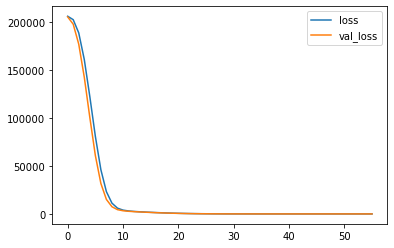

In [10]:
loss_df = pd.DataFrame(ann.history.history)
loss_df.plot()

In [11]:
predictions  = ann.predict(X_test)
predictions_df = pd.DataFrame(np.ravel(predictions),columns=['Predictions'])
comparison_df = pd.concat([pd.DataFrame(y_test,columns=['Real Values']),predictions_df],axis=1)
comparison_df

60/60 [==============================] - 0s 718us/step


,Real Values,Predictions
0,431.07,431.750244
1,442.60,442.327698
2,452.45,450.669525
3,453.94,451.904755
4,432.00,433.029022
...,...,...
1909,480.71,475.322388
1910,485.36,480.665955
1911,440.08,443.479645
1912,433.71,442.436432


###  evaluation of the predictions

The next graph show that the model fit pretty well the real data.
Fact which is again proved with a R2 coefficient (explained variance coeff) of ~0.92 

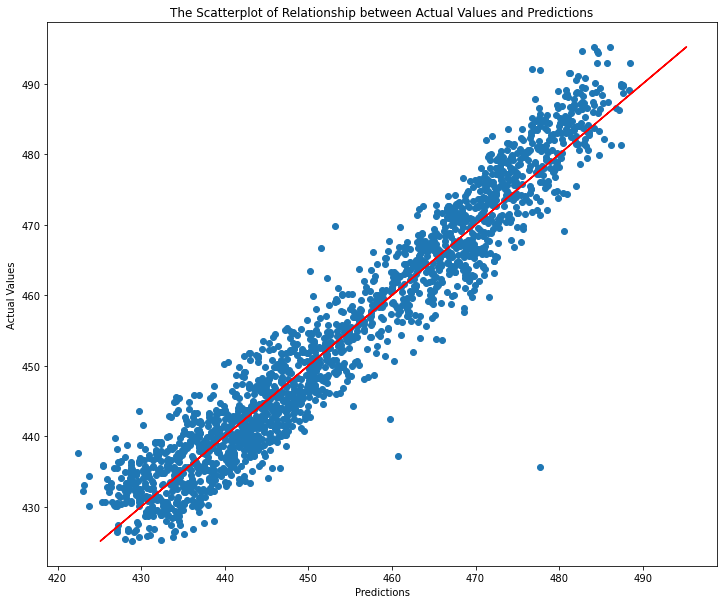

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.scatter(np.ravel(predictions), y_test)
plt.plot(y_test,y_test, 'r')
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()

In [13]:
from sklearn import metrics

print("MAE:",metrics.mean_absolute_error(y_test,predictions))
print ("MSE:",metrics.mean_squared_error(y_test,predictions))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 3.6804619640641327
MSE: 21.26568140865345
RMSE: 4.611472802549469


In [14]:
metrics.explained_variance_score(y_test,predictions)

0.9289429155112607